In [3]:
from tensorflow.examples.tutorials.mnist import input_data

minst_data = input_data.read_data_sets('MINST_data/',reshape=False)
X_train, y_train = minst_data.train.images, minst_data.train.labels
X_validation, y_validation = minst_data.validation.images, minst_data.validation.labels
X_test, y_test = minst_data.test.images, minst_data.test.labels

assert (len(X_train) == len(y_train))
assert (len(X_validation) == len(y_validation))
assert (len(X_test) == len(y_test))

print("Image shape: {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MINST_data/train-images-idx3-ubyte.gz
Extracting MINST_data/train-labels-idx1-ubyte.gz
Extracting MINST_data/t10k-images-idx3-ubyte.gz
Extracting MINST_data/t10k-labels-idx1-ubyte.gz
Image shape: (28, 28, 1)
Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


In [4]:
import numpy as np

X_train = np.pad(X_train,((0,0),(2,2),(2,2),(0,0)),'constant')
X_validation = np.pad(X_validation,((0,0),(2,2),(2,2),(0,0)),'constant')
X_test = np.pad(X_test,((0,0),(2,2),(2,2),(0,0)),'constant')

print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


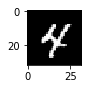

4


In [6]:
#查看图片
import random 
import matplotlib.pyplot as plt

index = random.randint(0,len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image,cmap='gray')
plt.show()
print(y_train[index])

In [7]:
#打乱数据
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

In [10]:
import tensorflow as tf
EPOCHS = 10
BATCH_SIZE = 128
'''
input: 32*32*c 
结构：
layer1:卷积, output_size: 28*28*6
activation: relu
pooling: output_size: 14*14*6
layer2:卷积, output_size: 10*10*6
activation: relu
pooling: output_size: 5*5*16
flatten
layer3:Full Connected 120 outputs
activation: relu
layer4:Full Connected 84 outputs
activation: relu
layer5:Full Connected 10 outputs
'''

from  tensorflow.contrib.layers import flatten

def LeNet(x):
    mu = 0
    sigma = 0.1
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6),mean=mu,stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x,conv1_w,strides=[1,1,1,1],padding='VALID') + conv1_b
    
    conv1 = tf.nn.relu(conv1)
    
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean=mu,stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1,conv2_w,strides=[1,1,1,1],padding='VALID') + conv2_b
    
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    fc0 = flatten(conv2)
    
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400,120),mean=mu,stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0,fc1_w) + fc1_b
    
    fc1   = tf.nn.relu(fc1)

    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84),mean=mu,stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1,fc2_w) + fc2_b
    
    fc2   = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [11]:
x = tf.placeholder(tf.float32,(None,32,32,1))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y,10)

In [12]:
#training pipline
rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.970

EPOCH 2 ...
Validation Accuracy = 0.982

EPOCH 3 ...
Validation Accuracy = 0.983

EPOCH 4 ...
Validation Accuracy = 0.984

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.988

EPOCH 7 ...
Validation Accuracy = 0.988

EPOCH 8 ...
Validation Accuracy = 0.985

EPOCH 9 ...
Validation Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.988

Model saved


In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test,y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.988
